<a href="https://colab.research.google.com/github/ssuzana/Machine-Learning-Notebooks/blob/main/Ensemble_Methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

* If you aggregate the predictions of a group of predictors (such as classifiers or regressors), you will often get better predictions than with the best individual predictor. 

* A group of predictors is called an **ensemble**; thus, this technique is called **ensemble learning**, and an ensemble learning algorithm is called an **ensemble method**.

* Ensemble methods are used near the end of a project, once a few good predictors have already been built, to combine them into an even better predictor. 

* Ensemble methods work best when the predictors are as independent from one another as possible. One way to get diverse classifiers is to train them using very different algorithms. This increases the chance that they will make very different types of errors, improving the ensemble’s accuracy.

* We will examine the most popular ensemble methods, including voting classifiers, bagging and pasting ensembles, random forests, boosting, and stacking ensembles.

* Ensemble methods are versatile, powerful, and fairly simple to use. Random forests, AdaBoost, and GBRT are among the first models you should test for most machine learning tasks, and they particularly shine with heterogeneous tabular data. Moreover, as they require very little preprocessing, they’re great for getting a prototype up and running quickly. Lastly, ensemble methods like voting classifiers and stacking classifiers can help push your system’s performance to its limits.

# Why ensemble methods can work better than individual classifiers alone

* We will make the assumption that all $n$ base classifiers for a binary classification task have an equal error rate, $\varepsilon$. 

* Furthermore, we will assume that the classifiers are independent and the error rates are not correlated. 

* Under these assumptions, we can express the error probability of an ensemble of base classifiers as a probability mass function of a binomial distribution. The overall error of a classification ensemble containing these classifiers is given by the probability that more than half of the classifiers simultaneously predict the erroneous class label:

$$\varepsilon_{\text{ensemble}} = P(y\geq k)= \sum_{k=\left\lceil \frac{n}{2} \right\rceil}^n {n\choose k}\varepsilon^k (1-\varepsilon)^{n-k}.$$

* For example, consider an ensemble of 11 base classifiers, where each classifier has an error rate $\varepsilon = 0.25$. Then the probability that the prediction of the ensemble is wrong is given by:

$$\varepsilon_{\text{ensemble}} = P(y\geq k)= \sum_{k=6}^{11} {11\choose k}0.25^k (1-0.25)^{11-k}=0.034.$$
   
   * The error rate of the ensemble (0.034) is much lower than the error rate of each individual classifier (0.25) **if all the assumptions are met**. 

   * The key assumptions in the previous analysis are that the errors of the classifiers
are independent and that the individual error probabilities are $\varepsilon$ with $\varepsilon < 1/2$. In the case that $\varepsilon$ is larger than 1/2, a different behavior for the ensemble error is observed.

* The effectiveness of the ensemble relies on both the individual accuracy of the different
ensemble members and the independence of their errors (ensemble diversity).


In [1]:
from scipy.special import comb
import math
def ensemble_error(n_classifier, error):
  k_start = int(math.ceil(n_classifier / 2.))
  probs = [comb(n_classifier, k) * error**k * (1-error)**(n_classifier - k) 
           for k in range(k_start, n_classifier + 1)]
  return sum(probs)

In [2]:
ensemble_error(n_classifier=11, error=0.25)

0.03432750701904297

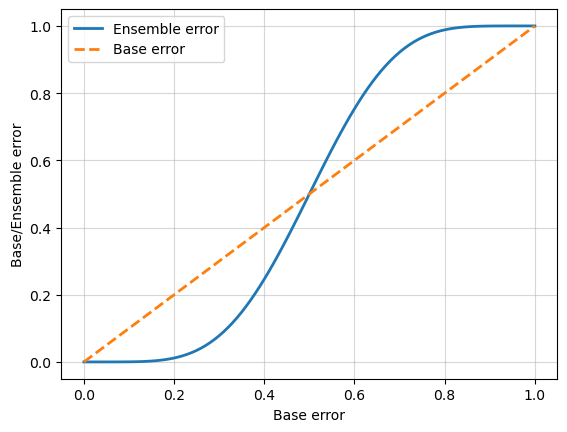

In [3]:
import numpy as np
import matplotlib.pyplot as plt
error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(n_classifier=11, error=error) for error in error_range]
plt.plot(error_range, ens_errors,
         label='Ensemble error',
         linewidth=2)
plt.plot(error_range, error_range, 
         linestyle='--', label='Base error',
         linewidth=2)
plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.show()

# Voting Classifiers





## Hard Voting (majority vote)

* Suppose you have trained a few classifiers: a logistic regression classifier, an SVM classifier, a random forest classifier, a k-nearest neighbors classifier, and perhaps a few more. 

* A very simple way to create an even better classifier is to aggregate the predictions of each classifier: the class that gets the most votes is the ensemble’s prediction. This majority-vote classifier is called a **hard voting classifier**.

* Scikit-Learn provides a `VotingClassifier` class that’s quite easy to use: just give it a list of name/predictor pairs, and use it like a normal classifier.

* When you fit a `VotingClassifier`, it clones every estimator and fits the clones. The original estimators are available via the `estimators` attribute, while the fitted clones are available via the `estimators_` attribute. If you prefer a dict rather than a list, you can use `named_estimators` or `named_estimators_` instead.

* When you call the voting classifier’s `predict()` method, it performs hard voting.

In [4]:
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, VotingClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [5]:
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [6]:
voting_clf = VotingClassifier(
        estimators=[
            ('lr', LogisticRegression(random_state=42)),
            ('rf', RandomForestClassifier(random_state=42)),
            ('svc', SVC(random_state=42))
            ] )
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [7]:
for name, clf in voting_clf.named_estimators_.items():
  print(name, "=", clf.score(X_test, y_test))

lr = 0.864
rf = 0.896
svc = 0.896


In [8]:
[clf.predict(X_test[:1]) for clf in voting_clf.estimators_]

[array([1]), array([1]), array([0])]

In [9]:
# hard voting
voting_clf.predict(X_test[:1])

array([1])

In [10]:
# performance of the voting classifier on the test set
voting_clf.score(X_test, y_test)

0.912

## Soft Voting (weighted majority vote based on class probabilities)

* If all classifiers are able to estimate class probabilities (i.e., if they all have a `predict_proba()` method), then you can tell Scikit-Learn to predict the class with the highest class probability, averaged over all the individual classifiers. This is called **soft voting**. It often achieves higher performance than hard voting because it gives more weight to highly confident votes.

* All you need to do is set the voting classifier’s voting hyperparameter to `"soft"`, and ensure that all classifiers can estimate class probabilities.

In [11]:
voting_clf.voting = "soft"
voting_clf.named_estimators["svc"].probability = True

In [12]:
voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)

0.92

# Bagging and Pasting

* Another way to get a diverse set of classifiers is to use the same training algorithm for every predictor but train them on different random subsets of the training set. 

* When sampling is performed with replacement, this method is called **bagging** (short for **bootstrap aggregating**). When sampling is performed without replacement, it is called **pasting**. Note that in statistics, resampling with replacement is called bootstrapping.

* **Scalability.** Bagging and pasting scale very well. Predictors can all be trained in parallel, via different CPU cores or even different servers. Similarly, predictions can be made in parallel.

* Once all predictors are trained, the ensemble can make a prediction for a new instance by simply aggregating the predictions of all predictors. 

 The aggregation function is typically the statistical **mode** for classification (i.e., the most frequent prediction, just like with a hard voting classifier), or the **average** for regression.

* **Bias and variance.** Each individual predictor has a higher bias than if it were trained on the original training set, but aggregation reduces both bias and variance.

 Generally, the net result is that the ensemble has a similar bias but a lower variance than a single predictor trained on the original training set.  

## Bagging and Pasting in Scikit-Learn

* Scikit-Learn offers a simple API for both bagging and pasting: [BaggingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) class or [BaggingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html) for regression. 

* A `BaggingClassifier` automatically performs soft voting instead of hard voting if the base classifier can estimate class probabilities (i.e., if it has a `predict_proba()` method), which is the case with decision tree classifiers.

* We give below an example of bagging, but if you want to use pasting instead, just set `bootstrap=False`. 

* Bagging introduces a bit more diversity in the subsets that each predictor is trained on, so bagging ends up with a slightly higher bias than pasting; but the extra diversity also means that the predictors end up being less correlated, so the ensemble’s variance is reduced. 

 Overall, bagging often results in better models, which explains why it’s generally preferred. But if you have spare time and CPU power, you can use cross-validation to evaluate both bagging and pasting and select the one that works best.


In [13]:
from sklearn.ensemble import BaggingClassifier 
from sklearn.tree import DecisionTreeClassifier

In [14]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), 
                            n_estimators=500,
                            max_samples=100,
                            n_jobs=-1, # use all available CPU cores
                            random_state=42)
bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, random_state=42)

# Random Forests

A **random forest** is an ensemble of decision trees, generally trained via the bagging method (or sometimes pasting), typically with `max_samples` set to the size of the training set. 

Instead of building a `BaggingClassifier` and passing it a `DecisionTreeClassifier`, you can use the [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) class, which is more convenient and optimized for decision trees (similarly, there is a [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) class for regression tasks).

The random forest algorithm introduces extra randomness when growing trees; instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features. By default, it samples $\sqrt{n}$ features (where $n$ is the total number of features). The algorithm results in greater tree diversity, which (again) trades a higher bias for a lower variance, generally yielding an overall better model.

In [82]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

rnd_clf = RandomForestClassifier(n_estimators=500, # random forest classifier with 500 trees
                                 max_leaf_nodes=16, # each tree is limited to maximum 16 leaf nodes
                                 n_jobs=-1, # use all available CPU cores
                                 random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

In [84]:
# BaggingClassifier equivalent to the previous RandomForestClassifier:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, 
    n_jobs=-1, 
    random_state=42)

## Extremely Randomized Trees (or Extra-Trees)

 It is possible to make trees even more random by also using **random thresholds for each feature** rather than searching for the best possible thresholds (like regular decision trees do). For this, simply set `splitter="random"` when creating a `DecisionTreeClassifier`. A forest of such extremely random trees is called an extremely randomized trees (or extra-trees) ensemble. 
 
This technique trades more bias for a lower variance. It also makes extra-trees classifiers much faster to train than regular random forests, because finding the best possible threshold for each feature at every node is one of the most time-consuming tasks of growing a tree.

You can create an extra-trees classifier using Scikit-Learn’s [ExtraTreesClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html) class. Its API is identical to the RandomForestClassifier class, except `bootstrap` defaults to `False`. Similarly, the [ExtraTreesRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html) class has the same API as the RandomForestRegressor class, except `bootstrap` defaults to `False`.


## Feature Importance

Random forests are very handy to get a quick understanding of what features actually matter, in particular if you need to perform feature selection.

In [86]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)

rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris.data, iris.target)

for score, name in zip(rnd_clf.feature_importances_, iris.data.columns):
    print(round(score, 2), name)

0.11 sepal length (cm)
0.02 sepal width (cm)
0.44 petal length (cm)
0.42 petal width (cm)


It seems that the most important features for the iris dataset are the petal length (44%) and width (42%), while sepal length and width are rather unimportant in comparison (11% and 2%, respectively).

# Boosting

## AdaBoost


* Boosting refers to any ensemble method that can combine several weak learners into a strong learner. The general idea of most boosting methods is to train predictors sequentially, each trying to correct its predecessor. 

* There are many boosting methods available, but by far the most popular are **AdaBoost** (short for adaptive boosting) and **gradient boosting**.

### AdaBoost overview

* The core principle of AdaBoost is to fit a sequence of weak learners (i.e., models that are only slightly better than random guessing, such as small decision trees) on repeatedly modified versions of the data. The predictions from all of them are then combined through a weighted majority vote (or sum) to produce the final prediction.

*  When training an AdaBoost classifier, the algorithm first trains a base classifier and uses it to make predictions on the training set. The algorithm then **increases the relative weight of misclassified training instances**. Then it trains a second classifier, using the updated weights, and again makes predictions on the training set, updates the instance weights, and so on.

* Once all predictors are trained, the ensemble makes predictions very much like bagging or pasting, except that predictors have different weights depending on their overall accuracy on the weighted training set.

* The more accurate the predictor is, the higher its weight will be. If it is just guessing randomly, then its weight will be close to zero. However, if it is most often wrong (i.e., less accurate than random guessing), then its weight will be negative.

* One important drawback to this sequential learning technique: **training cannot be parallelized** since each predictor can only be trained after the previous predictor has been trained and evaluated. As a result, it does not scale as well as bagging or pasting.

### AdaBoost training

* Each instance weight $w^{(i)}$ is initially set to $\frac{1}{m}$, where $m$ is the number of training examples.

* A first predictor is trained, and its **weighted error rate** $r_1$ is computed on the training set using the equation (with $j=1$):

$$r_j =  \sum_{\substack{i=1 \\ \widehat{y}_j^{(i)}\neq y^{(i)}}}^m w^{(i)} $$
  where $\widehat{y}_j^{(i)}$ is the $j$-th predictor's prediction for the $i$-th instance.

* Then the predictor's **weight** $\alpha_j$ is computed using the equation:

$$ \alpha_j = \eta \log \frac{1-r_j}{r_j}$$
where $\eta$ is the learning rate hyperparameter (defaults to 1).
    
* Next, the **instance weights** are updated, boosting the weights of the misclassified instances:

$$ w^{(i)} \leftarrow \begin{cases} w^{(i)} & \text{ if } \widehat{y}_j^{(i)} = y^{(i)} \\ w^{(i)}\exp(\alpha_j) & \text{ if } \widehat{y}_j^{(i)} \neq  y^{(i)}\end{cases}$$

* Then all the instance weights are normalized, i.e., divided by $\sum_{i=1}^m w^{(i)}.$

* Finally, a new predictor is trained using the updated weights, and the whole process is repeated: the new predictor’s weight is computed, the instance weights are updated, then another predictor is trained, and so on. 

* The algorithm stops when the desired number of predictors is reached, or when a perfect predictor is found.





### AdaBoost predictions

* To make predictions, AdaBoost simply computes the predictions of all the predictors and weighs them using the predictor weights $\alpha_j$. 

 The predicted class is the one that receives the majority of weighted votes:

$$\widehat{y}(\mathbf{x}) = \text{argmax} \sum_{\substack{j=1 \\ \widehat{y}_j^{(i)}(\mathbf{x}) = k}}^N \alpha_j$$
where $N$ is the number of predictions.




### AdaBoost in Scikit-Learn

* The following code trains an AdaBoost classifier based on 30 decision stumps (decision trees with max_depth=1) using Scikit-Learn’s `AdaBoostClassifier` class (as you might expect, there is also an AdaBoostRegressor class):


In [15]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=30,
    learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=30, random_state=42)

In [17]:
ada_clf.score(X_test, y_test)

0.904

## Multiclass AdaBoost: SAMME and SAMME.R

* Scikit-Learn uses a multiclass version of AdaBoost called **SAMME** (which stands for *Stagewise Additive Modeling using a Multiclass Exponential loss function*). 

 When there are just two classes, SAMME is equivalent to AdaBoost. 
 
*  If the predictors can estimate class probabilities, Scikit-Learn can use a variant of SAMME called **SAMME.R** (the R stands for “Real”), which relies on class probabilities rather than predictions and generally performs better.


## Gradient Boosting

* Gradient boosting works by sequentially adding predictors to an ensemble, each one correcting its predecessor. However, instead of tweaking the instance weights at every iteration like AdaBoost does, this method tries to **fit the new predictor to the residual errors made by the previous predictor**.

### Regression Example - Gradient Tree Boosting, or Gradient Boosted Regression Trees (GBRT)




You can use Scikit-Learn’s [GradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html) class to train GBRT ensembles (using Decision Trees as base predictors). There’s also a [GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) class for classification.



In [29]:
#create a simple quadratic dataset
import numpy as np
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(100)  # y = 3x² + Gaussian noise

In [31]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2,
                                 n_estimators=3,
                                 learning_rate=1.0, #scales the constribution of each tree
                                 random_state=42)
gbrt.fit(X,y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

* To find the optimal number of trees in the ensemble, you set the `n_iter_no_change` hyperparameter to an integer value, say 10, then the Gradient BoostingRegressor will automatically stop adding more trees during training if it sees that the last 10 trees didn’t help. This is simply **early stopping**, but with a little bit of patience: it tolerates having no progress for a few iterations before it stops. 

* When `n_iter_no_change` is set, the `fit()` method automatically splits the training set into a smaller training set and a validation set: this allows it to evaluate the model’s performance each time it adds a new tree. The size of the validation set is controlled by the `validation_fraction` hyperparameter, which is 10% by default.

In [33]:
gbrt_best = GradientBoostingRegressor(max_depth=2, 
                                      learning_rate=0.05, 
                                      n_estimators=500,
                                      n_iter_no_change=10, # if too low, training may stop too early and the model will underfit 
                                      random_state=42)
gbrt_best.fit(X, y)

GradientBoostingRegressor(learning_rate=0.05, max_depth=2, n_estimators=500,
                          n_iter_no_change=10, random_state=42)

In [34]:
gbrt_best.n_estimators_

92

### Stochastic gradient boosting

The [GradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html) and the [GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) classes also support a `subsample` hyperparameter, which specifies the fraction of training instances to be used for fitting the individual base learners. For example, if `subsample=0.25`, then each learner is trained on 25% of the training instances, selected randomly. Choosing subsample < 1.0 leads to a reduction of variance and an increase in bias. Values must be in the range (0.0, 1.0]. If smaller than 1.0 this results in **Stochastic Gradient Boosting.** 


### Histogram-Based Gradient Boosting

Scikit-Learn also provides another GBRT implementation, optimized for large datasets: histogram-based gradient boosting (HGB). It works by binning the input features, replacing them with integers.  Binning can greatly reduce the number of possible thresholds that the training algorithm needs to evaluate. Moreover, working with integers makes it possible to use faster and more memory-efficient data structures. And the way the bins are built removes the need for sorting the features when training each tree.

Scikit-Learn provides two classes for HGB: [HistGradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html) and [HistGradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html). 

They’re similar to GradientBoostingRegressor and GradientBoostingClassifier, with a few notable differences:
* Early stopping is automatically activated if the number of instances is greater than 10,000. You can turn early stopping always on or always off by setting the `early_stopping` hyperparameter to True or False.
* Subsampling is not supported.
* `n_estimators` is renamed to `max_iter`.
* The only decision tree hyperparameters that can be tweaked are `max_leaf_nodes`, `min_samples_leaf`, and `max_depth`.

In [71]:
# get California housing data

import pandas as pd
from sklearn.model_selection import train_test_split
import tarfile
import urllib.request
from pathlib import Path

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

In [72]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [73]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
housing_labels = train_set["median_house_value"]
housing = train_set.drop("median_house_value", axis=1)

The HGB classes have two nice features: they support both categorical features and missing values. This simplifies preprocessing quite a bit. However, the categorical features must be represented as integers ranging from `0` to a number lower than `max_bins`. You can use an [OrdinalEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html) for this. Also see [make_column_transformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_transformer.html).

In [75]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OrdinalEncoder 

hgb_reg = make_pipeline(
    make_column_transformer((OrdinalEncoder(), ["ocean_proximity"]),
                            remainder="passthrough"),
    HistGradientBoostingRegressor(categorical_features=[0], # must be set to the categorical column indices (or a Boolean array)
                                  random_state=42)
)
hgb_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['ocean_proximity'])])),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor(categorical_features=[0],
                                               random_state=42))])

In [68]:
# evaluate the RMSE stats for the hgb_reg model

from sklearn.model_selection import cross_val_score

hgb_rmses = -cross_val_score(hgb_reg, housing, housing_labels,
                             scoring="neg_root_mean_squared_error", cv=10)
pd.Series(hgb_rmses).describe()

count       10.000000
mean     47613.307194
std       1295.422509
min      44963.213061
25%      47001.233485
50%      48000.963564
75%      48488.093243
max      49176.368465
dtype: float64

In [69]:
pd.Series(hgb_rmses).mean()

47613.307194169436

## Optimized implementations of Gradient Boosting

Several other optimized implementations of gradient boosting are available in the Python ML ecosystem: in particular, [XGBoost](https://github.com/dmlc/xgboost), [Cat‐Boost](https://catboost.ai/), and [LightGBM](https://lightgbm.readthedocs.io/en/v3.3.2/). They are all specialized for gradient boosting, their APIs are very similar to Scikit-Learn’s, and they provide many additional features, including GPU acceleration. 
Moreover, the [TensorFlow Random Forests library](https://www.tensorflow.org/decision_forests) provides optimized implementations of a variety of random forest algorithms, including plain random forests, extra-trees, GBRT, and several more.

# Stacking (or [stacked generalization](https://scikit-learn.org/stable/modules/ensemble.html#stacking))

Stacking is a method for combining estimators to reduce their biases. More precisely, the predictions of each individual estimator are stacked together and used as input to a final estimator to compute the prediction. This final estimator is trained through cross-validation.

Scikit-Learn provides two classes for stacking ensembles: [StackingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html) and [StackingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingRegressor.html). For each predictor, the stacking classifier will call `predict_proba()` if available; if not it will fall back to `decision_function()` or, as a last resort, `call predict()`. If you don’t provide a final estimator, `StackingClassifier` will use `LogisticRegression` and `StackingRegressor` will use `RidgeCV`.

In [77]:
from sklearn.ensemble import StackingClassifier
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

stacking_clf = StackingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(probability=True, random_state=42))
    ],
    final_estimator=RandomForestClassifier(random_state=43),
    cv=5  # number of cross-validation folds
)
stacking_clf.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('lr', LogisticRegression(random_state=42)),
                               ('rf', RandomForestClassifier(random_state=42)),
                               ('svc', SVC(probability=True, random_state=42))],
                   final_estimator=RandomForestClassifier(random_state=43))

In [80]:
print(f"{round(stacking_clf.score(X_test, y_test)*100,2)} % accuracy")

92.8 % accuracy


# References:

* [Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, by Aurélien Géron.](https://www.oreilly.com/library/view/hands-on-machine-learning/9781098125967/)

* [Machine Learning with PyTorch and Scikit-Learn, by Sebastian Raschka, Yuxi (Hayden) Liu,  Vahid Mirjalili](https://www.packtpub.com/product/machine-learning-with-pytorch-and-scikit-learn/9781801819312)

* https://scikit-learn.org/stable/modules/ensemble.html